<a href="https://colab.research.google.com/github/BRCAChallenge/pubMunch-BRCA/blob/master/stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Literature Search Crawl Report

See [normalize.py](https://github.com/BRCAChallenge/pubMunch-BRCA/blob/master/normalize.py) for details on how the output of pubMunch is normalized into genomic HGVS and [export.ipynb](https://github.com/BRCAChallenge/pubMunch-BRCA/blob/master/export.ipynb) for details on how these normalized artifacts are exported into literature.json

In [1]:
import os
import requests
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
    
base_url = "http://public.gi.ucsc.edu/~rcurrie/pubMunch/crawl-2018-11-14"
print("Date of crawl: 2018-11-14")

Date of crawl: 2018-11-14


## Download

In [2]:
pmids = requests.get("{}/download/pmids.txt".format(base_url)).text.splitlines()
print("{} PMIDs attempted".format(len(pmids)))

16980 PMIDs attempted


In [3]:
download = pd.read_table("{}/download/docStatus.tab".format(base_url), 
                           header=None, index_col=False, dtype=str,
                           names=["pmid", "status", "msg", "crawler", "journal", "year", "numFiles", "detail"])

print("{} ({}%) succeeded\n {} ({}%) failed\n".format(
    download[download.status == "OK"].shape[0], 
    round(100 * download[download.status == "OK"].shape[0] / len(pmids)),
    download[download.status != "OK"].shape[0], 
    round(100 * download[download.status != "OK"].shape[0] / len(pmids))))
print(download.status.value_counts())

14088 (83%) succeeded
 2753 (16%) failed

OK                     14088
invalidPdf               978
noCrawlerSuccess         817
httpError                302
noLicense                301
HighwirePdfNotValid      254
invalidHostname           55
pageErrorMessage          28
no_meta                    9
noOutlinkOrDoi             6
HtmlParseError             1
tooManySupplFiles          1
BeautifulSoupError         1
Name: status, dtype: int64


## Find

In [4]:
mutations = pd.read_table("{}/mutations.tsv".format(base_url), header=0, dtype=str, index_col=False,
                          usecols=["docId", "hgvsProt", "hgvsCoding", "hgvsRna", "mutSnippets"])
mutations = mutations.rename({"docId": "pmid"}, axis="columns")
print("{} mutations found by varFinder".format(mutations.shape[0]))

428338 mutations found by varFinder


In [5]:
mentions = pd.read_table("{}/mentions-normalized.tsv".format(base_url), index_col="norm_g_hgvs")
mentions.pmid = mentions.pmid.astype(str)
print("{} mutations successfully normalized into HGVS genomic coordinates".format(mentions.shape[0]))
mentions[::5000].head()

442198 mutations successfully normalized into HGVS genomic coordinates


,norm_c_hgvs,pmid,snippet
norm_g_hgvs,,,
NC_000007.14:g.96709760A>C,NM_006304.1:c.4T>G,12228710,"ee-stranded β sheet with OB2β1 and OB2β2, as w..."
NC_000005.10:g.112767387A>G,NM_001127511.2:c.449A>G,28503720,Mutation ER/HER2 Ethnicity Fami...
NC_000023.11:g.107645290del,NM_001204402.1:c.32del,25742137,"q,36.1,CGCACTCAGCAAGGCCTCCTGCCCTGAGAGAGGCTCCGC..."
NC_000012.12:g.21563301C>T,NM_021957.3:c.868G>A,25742137,"19:50109252-50109549 cg00397740,1,159402945,NC..."
NC_000020.11:g.45911447G>T,NM_006227.3:c.6C>A,25742137,go_function: receptor activity; go_function: r...


In [6]:
lit = requests.get("{}/literature.json".format(base_url)).json()
print("{} Papers and {} Variants exported".format(len(lit["papers"]), len(lit["variants"])))

2227 Papers and 3754 Variants exported


## LOVD

In [7]:
lovd = pd.read_table(
    "https://raw.githubusercontent.com/BRCAChallenge/pubMunch-BRCA/master/tests/lovd-normalized.tsv", dtype=str)
print("{} pmids and {} variants in normalized LOVD truth set".format(
    len(set(lovd.pmid.values)),
    len(set(lovd.pyhgvs_Genomic_Coordinate_38.values))))
lovd.head()

175 pmids and 1044 variants in normalized LOVD truth set


,pmid,norm_c_hgvs,norm_g_hgvs,pyhgvs_Genomic_Coordinate_38
0,24667779,NM_007294.3:c.-19-22_-19-21dup,NC_000017.11:g.43124146_43124147dup,chr17:g.43124146_43124147:dup
1,10459348,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
2,24667779,NM_007294.3:c.-19-10T>C,NC_000017.11:g.43124125A>G,chr17:g.43124125:A>G
3,16403807,NM_007294.3:c.-3G>C,NC_000017.11:g.43124099C>G,chr17:g.43124099:C>G
4,19393826,NM_007294.3:c.1_134del,NC_000017.11:g.43115728_43124098del,chr17:g.43115728_43124098:del


In [8]:
print("Missing from list of PMIDs to download:")
print(", ".join([p for p in set(lovd.pmid.values) if p not in pmids]))

print("\nFailed to download:")
print(", ".join(["{} ({})".format(p, download[download.pmid == p].status.values[0]) 
                   for p in set(lovd.pmid.values) if 
                   download[(download.pmid == p) & (download.status != "OK")].shape[0]]))

Missing from list of PMIDs to download:
07545954, 09523200, 09333265, 09805131, 09497265, 09971877, 08751436, 08942979, 07939630, 09585599, 12900794, 18415037, 2010, 08896551, 08531967, 19150617, 09126734

Failed to download:
15533909 (HighwirePdfNotValid), 16619214 (invalidPdf), 12815598 (invalidPdf), 20054658 (invalidPdf), 17279547 (invalidPdf), 17305420 (httpError), 16786532 (invalidPdf), 17657584 (invalidPdf), 12552570 (invalidPdf), 11385711 (invalidPdf), 18693280 (invalidPdf), 18375895 (HighwirePdfNotValid), 12955716 (invalidPdf), 18493658 (noCrawlerSuccess), 20020529 (invalidPdf), 12601471 (httpError), 19287957 (noCrawlerSuccess), 10406662 (invalidPdf), 16211554 (invalidPdf), 16528612 (invalidPdf), 15300854 (invalidPdf), 18680205 (invalidPdf), 16969499 (noCrawlerSuccess), 10506595 (HighwirePdfNotValid), 20513136 (invalidPdf), 12955719 (invalidPdf)


In [9]:
lit_pmids = set([pmid for variant, mentions in lit["variants"].items() for pmid in mentions.keys()])

common_pmids = list(lit_pmids.intersection(set(lovd.pmid.values)))
print("{} common pmids between LOVD and this crawl".format(len(common_pmids)))

117 common pmids between LOVD and this crawl


In [10]:
# Invert the literature.json exported to BRCA Exchange to create a variants by pmid from literature
import itertools

lit_pmid_variant_tuple = [(pmid, variant) 
                          for variant, mention in lit["variants"].items() 
                          for pmid in list(mention.keys())]

lit_variants_by_pmid = {pmid: [v[1] 
                        for v in variants]
                        for pmid, variants in itertools.groupby(sorted(lit_pmid_variant_tuple), lambda x: x[0])}

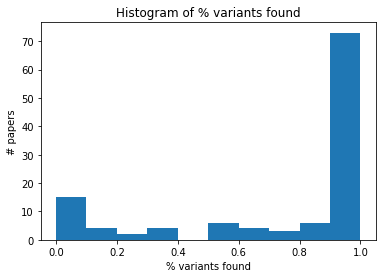

In [11]:
# Compute per paper the % of LOVD variants we found and exported in literature.json
pcts = {
    p: len(set(lit_variants_by_pmid[p]).intersection(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values))) / len(
        set(lovd[lovd.pmid == p].pyhgvs_Genomic_Coordinate_38.values)) 
    for p in common_pmids}

lovd_stats = pd.DataFrame.from_dict(pcts, orient="index", columns=["pct"]).rename_axis("pmid")

plt.hist(lovd_stats.pct)
plt.title("Histogram of % variants found")
plt.xlabel("% variants found")
plt.ylabel("# papers")
plt.show()

In [12]:
print("PMIDs with < 50% of the variants in LOVD found:")
print(", ".join([v for v in lovd_stats[lovd_stats.pct < 0.5].index.values]))

PMIDs with < 50% of the variants in LOVD found:
16280041, 14729053, 19423647, 24667779, 10638982, 18712473, 15876480, 18424508, 15001988, 12442171, 24395671, 15353005, 12142080, 18694767, 11573086, 11185744, 17899372, 22144684, 17924331, 14513821, 21673748, 12759930, 21741379, 18824701, 19043619
